# 🧠 NLP Project: Automated Review Analysis and Product Recommendations

> A Project for Ironhack AI/ML Bootcamp by **Luis Guimarães**

---

## 📌 Project Overview

This project automates the analysis of customer reviews for fashion products on Amazon using Natural Language Processing (NLP). The goal is to help small e-commerce businesses extract meaningful insights from large volumes of textual data — identifying product sentiment, clustering products, and generating helpful summaries for marketing and product teams.

---

## 🧪 Objectives

1. **Sentiment Classification**  
   Predict whether customer reviews are *positive*, *negative*, or *neutral* based on review text.

2. **Product Clustering**  
   Group products into meta-categories using semantic similarity.

3. **Review Summarization**  
   Summarize reviews (positive and negative) and generate product recommendations using generative AI.


In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

#Install required libraries
!pip install -q numpy sentence-transformers scikit-learn transformers openai

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!zcat /content/drive/MyDrive/amazon_review/reviews.json.gz | head -n 3


{"rating": 3.0, "title": "Arrived Damaged : liquid in hub locker!", "text": "Unfortunately Amazon in their wisdom (cough, cough) decided to ship the snowsuit in a vinyl bag with holes in it!  There was no other bag to protect the snowsuit inside vinyl bag with all the holes.  This is what happened:  Arrived in hub locker. It was the very top locker. Opened it & pulled the pkg out getting a very wet & nasty surprise at the same time. My senses were assaulted. Smells like tea tree oil. Feels like conditioner or lotion.  I can\u2019t understand how the delivery person a) didn\u2019t smell that mess when they shoved the pkg in b) didn\u2019t see the mess when they shoved it in - tho if they were short I guess that would explain it bc I\u2019m 5\u201910\u201d & I didn\u2019t see it until the pkg was in my hands. The locker was up high & dark, but I could smell it the minute I walked into the hub locker room. I happen to be extremely allergic to tea tree oil.  It\u2019s made from mellaleuca 

## Convert JSON to Parquet


In [6]:
import polars as pl

# Read reviews
reviews = pl.read_ndjson(
    "/content/drive/MyDrive/amazon_review/reviews.json.gz",
    n_rows=190000  # Increased from 200
)

# Read metadata by forcing all columns to be read as strings
# by setting infer_schema_length to 0.
meta = pl.read_ndjson(
    "/content/drive/MyDrive/amazon_review/metadata.json.gz",
    n_rows=190000 # Increased from 200
)

# Join
df = reviews.join(meta, left_on="asin", right_on="parent_asin", how="inner")

# Output
print(meta.columns)
print(df.shape)

print(reviews.head(5))
print(meta.head(5))

['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together']
(1304, 23)
shape: (5, 10)
┌────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ rating ┆ title      ┆ text       ┆ images    ┆ … ┆ user_id   ┆ timestamp ┆ helpful_v ┆ verified_ │
│ ---    ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ote       ┆ purchase  │
│ f64    ┆ str        ┆ str        ┆ list[stru ┆   ┆ str       ┆ i64       ┆ ---       ┆ ---       │
│        ┆            ┆            ┆ ct[4]]    ┆   ┆           ┆           ┆ i64       ┆ bool      │
╞════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 3.0    ┆ Arrived    ┆ Unfortunat ┆ [{"https: ┆ … ┆ AFKZENTNB ┆ 167793876 ┆ 0         ┆ true      │
│        ┆ Damaged :  ┆ ely Amazon ┆ //m.media ┆   ┆ Q7A7V7UXW ┆ 7351      ┆     

## Load with lazy loading using Polars

In [7]:


# Filter for clothing/fashion-related products
df = df.filter(
    df["main_category"]
      .cast(str)
      .str.to_lowercase()
      .str.contains("clothing|fashion|apparel|shoes|jewelry")
)

# Select and rename relevant fields
df = df.select([
    "asin",
    "text",
    "rating",
    df["title"], # title from reviews
    df["features"],
    df["description"],
    df["main_category"]
]).rename({
    "text": "reviewText",
    "rating": "stars",
    "title": "product_title",
    "main_category": "category"
})


# First, create both features_str and description_str columns
df = df.with_columns([
    df["features"].list.join(", ").alias("features_str"),
    df["description"].list.join(", ").alias("description_str")
])

# Then build the combined product context
df = df.with_columns([
    (
        df["product_title"].fill_null("") + " - " +
        df["features_str"].fill_null("") + " - " +
        df["description_str"].fill_null("")
    ).alias("product_context")
])

print(len(df))
#print(df.head())


1200


# Cleaning Data

In [9]:
import re
import polars as pl

print(f"Shape before cleaning: {df.shape}")

# 1. Drop missing or null values
df = df.drop_nulls(subset=['product_title', 'category'])
print(f"Shape after dropping nulls: {df.shape}")


# 2. Strip whitespace
df = df.with_columns([
    pl.col('product_title').cast(pl.Utf8).str.strip_chars().alias('product_title'), # Utf8 - avoids issues if the column have mixed types like numbers or nulls
    pl.col('category').cast(pl.Utf8).str.strip_chars().alias('category') #.str.strip_chars() - removes leading and trailing whitespace
])
print(f"Shape after stripping whitespace: {df.shape}")


# 3. Create a combined category column
df = df.with_columns([
    (pl.col('category') + ' ' + pl.col('product_title')).alias('combined_category')
])
print(f"Shape after creating combined_category: {df.shape}")


# 4. Filter by string length (ignore when it is too short)
df = df.filter(pl.col('combined_category').str.len_chars() > 10)
print(f"Shape after filtering by combined_category length: {df.shape}")


# 5. Drop duplicates
df = df.unique(subset=['combined_category'])
print(f"Shape after dropping duplicates: {df.shape}")


# 6. Helper: filter out short or meaningless reviews
def is_informative(text, min_words=5):
    if not isinstance(text, str):
        return False
    text = text.strip()
    if len(text.split()) < min_words:
        return False
    if re.fullmatch(r"[^\w\s]+", text):  # emoji/symbol-only
        return False
    return True

# 7. Apply filter to reviewText
df = df.filter(
    pl.col("reviewText").map_elements(is_informative, return_dtype=pl.Boolean)
)

print(f"Shape after filtering by reviewText informativeness: {df.shape}")

if df.height > 0:
    df.head()

Shape before cleaning: (1200, 10)
Shape after dropping nulls: (1200, 10)
Shape after stripping whitespace: (1200, 10)
Shape after creating combined_category: (1200, 11)
Shape after filtering by combined_category length: (1200, 11)
Shape after dropping duplicates: (1046, 11)
Shape after filtering by reviewText informativeness: (1002, 11)


## 4. Review Sentiment Classification
- Transform numbers into labels
- ground truth labels

In [10]:
def map_sentiment(stars):
    if stars <= 2:
        return "NEGATIVE"
    elif stars == 3:
        return "NEUTRAL"
    else:
        return "POSITIVE"

# Apply the function using map_elements
df = df.with_columns([
    pl.col('stars').map_elements(map_sentiment, return_dtype=pl.Utf8).alias('sentiment') # Added return_dtype
])

# Count values and display only the result
sentiment_counts = df.select([
    pl.col('sentiment').value_counts()
])

print(sentiment_counts) # Use print instead of implicit display

shape: (3, 1)
┌──────────────────┐
│ sentiment        │
│ ---              │
│ struct[2]        │
╞══════════════════╡
│ {"NEUTRAL",120}  │
│ {"POSITIVE",770} │
│ {"NEGATIVE",112} │
└──────────────────┘


## 5. Classify Sentiment with a Pretrained Transformer Model
 - sentiment-roberta-large-english
 - zero-shot

In [11]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

# zero-shot
# Use a pretrained sentiment analysis model
#model_pipeline = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english", device=device)

model_pipeline = pipeline(
    "sentiment-analysis",
    model="siebert/sentiment-roberta-large-english",
    device=device,
    truncation=True
)

# Apply the model to the data already cleaned
df = df.with_columns([
    pl.col('reviewText').map_elements(lambda x: model_pipeline(x)[0]['label']).alias('model_sentiment')
])
# Data cleaned and labeled

print(df.shape) # Print shape instead of displaying head
if df.height > 0:
    df.head() # Display head only if not empty

Device set to use cuda:0
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dty

(1002, 13)


# Evaluation

In [12]:
# Just remove neutral, which is noisy
df_binary = df.filter(pl.col('sentiment') != 'NEUTRAL')

from sklearn.metrics import classification_report, confusion_matrix

#Use a sample of the data 1k
df_sample = df_binary.sample(n=min(20000, df_binary.height), seed=42)

# Inference label for comparison
texts = df_sample['reviewText'].to_list()
preds = []
for text in texts:
    short_text = text[:512]
    result = model_pipeline(short_text)
    label = result[0]['label']
    preds.append(label)

# Add the results as a new column
df_sample = df_sample.with_columns([
    pl.Series(name="model_sentiment", values=preds)
])


# Compare predictions with ground truth
y_true = df_sample['sentiment']
y_pred = preds


## Classification Report

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.9569160997732427

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.77      0.95      0.85       112
    POSITIVE       0.99      0.96      0.97       770

    accuracy                           0.96       882
   macro avg       0.88      0.95      0.91       882
weighted avg       0.96      0.96      0.96       882


Confusion Matrix:
 [[106   6]
 [ 32 738]]


# Confution Matrix

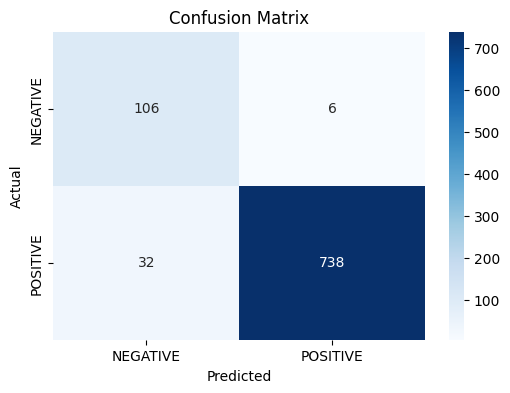

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["NEGATIVE", "POSITIVE"])
labels = ["NEGATIVE", "POSITIVE"]

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Labeling clusters

In [15]:
# Make the data consistent for vectorization
df = df.with_columns([
    pl.col("category")
      .cast(pl.Utf8)
      .str.to_lowercase() #convert to lower case
      .str.replace_all(r"[^a-z\s]", "")  # remove non-letters
      .alias("category")
])

# Preparing data for embedding
df = df.with_columns([
    (pl.col('category') + ' ' + pl.col('product_title')).alias('combined_category')
])


# Embeddings - Group reviews into meta-categories

In [16]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Embedding: Loads a pretrained model to turns text into numerical vectors
model = SentenceTransformer('all-MiniLM-L6-v2')
texts = df.select("combined_category").to_series().to_list()

embeddings = model.encode(texts, show_progress_bar=True)

# Group
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)


df = df.with_columns([
    pl.Series(name="meta_cluster", values=labels)
])

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

# Inspect items per cluster to pick some and be able to proceed

In [25]:
for i in range(5): # Update range to 2 since n_clusters is now 2
    print(f"\nCluster {i}:")
    items = (
        df.filter(pl.col("meta_cluster") == i)
          .select("combined_category")
          .unique()
          .head(5)
          .to_series()
          .to_list()
    )
    for item in items:
        print(" -", item)


Cluster 0:
 - amazon fashion Beautiful but not uniform sizing
 - amazon fashion Runs Small
 - amazon fashion not skin tight
 - amazon fashion Extremely oversized, meh overall look
 - amazon fashion Good product, wish it was a little bit bigger

Cluster 1:
 - amazon fashion Perfect hiking shoe
 - amazon fashion Great running shoes
 - amazon fashion Great dress shoe.
 - amazon fashion great boots!
 - amazon fashion These are some delightful socks

Cluster 2:
 - amazon fashion LOVE THEM!
 - amazon fashion Poor quality
 - amazon fashion Gift
 - amazon fashion Fashionable and practical.
 - amazon fashion What an indulgence!

Cluster 3:
 - amazon fashion Cute and nicely fit summer night gown
 - amazon fashion Great shorts, great comfort
 - amazon fashion This is a great come a warm casual sweater that you could wear ...
 - amazon fashion Warmth and comfort is a must to enjoy the snow!
 - amazon fashion Probably great for shapewear, but not for off-label back support

Cluster 4:
 - amazon fa

#Defining the clusterings

In [26]:
# Cluster labels using one representative sample per cluster
cluster_labels = {}

for i in range(5):  # Update range to 2
    # Get 1 clean sample per cluster
    example = (
        df.filter(pl.col("meta_cluster") == i)
          .select("combined_category")
          .unique()
          .head(1)
          .to_series()
          .to_list()
    )
    if example:
        cluster_labels[str(i)] = example[0]  # must cast to str if meta_cluster is str later

# Apply cluster labels dynamically
df = df.with_columns(
    pl.col("meta_cluster").cast(str).replace(cluster_labels).alias("cluster_label")
)

# Plotting Product Distribution

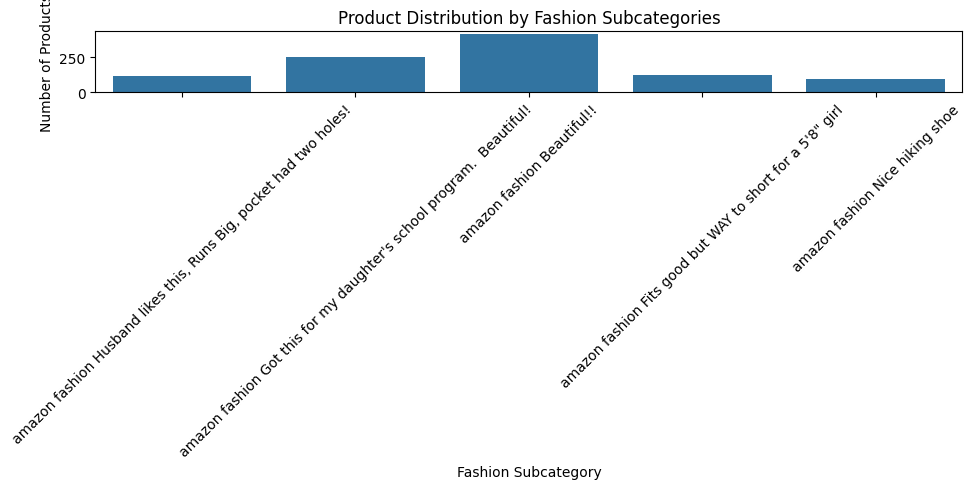

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert only what's needed to Pandas
df_pd = df.select(["cluster_label"]).to_pandas()

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(data=df_pd, x='cluster_label')
plt.title('Product Distribution by Fashion Subcategories')
plt.xlabel('Fashion Subcategory')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Summarization

In [28]:

# Load summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0 if torch.cuda.is_available() else -1)

def summarize_text(text, max_length=130, min_length=30):
    try:
        input_length = len(text.split())
        # Dynamically adjust max_length
        if input_length < min_length:
            return text  # Too short to summarize
        elif input_length < max_length:
            max_length = int(input_length * 0.8)
            min_length = int(max_length * 0.5)

        summary = summarizer(text[:1024], max_length=max_length, min_length=min_length, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        return f"Error: {str(e)}"

# Example usage
sample_review = df['reviewText'][0]
print("Original:", sample_review)
print("Summary:", summarize_text(sample_review))


Device set to use cuda:0


Original: This is a trifold wallet that is a bit bulky by design. It is still a very nice product. It has room for 12 credit cards. It is a bit much.
Summary: This is a trifold wallet that is a bit bulky by design. It has room for 12 credit


In [29]:

# Make summary of reviews
def summarize_individual_reviews(df, count=5):
    df_positive = df.filter(pl.col("sentiment") == "POSITIVE").head(count)
    df_negative = df.filter(pl.col("sentiment") == "NEGATIVE").head(count)

    positive_summaries = [
        summarize_text(text) for text in df_positive["reviewText"].to_list()
    ]

    negative_summaries = [
        summarize_text(text) for text in df_negative["reviewText"].to_list()
    ]

    return {
        "positive_reviews": positive_summaries,
        "negative_reviews": negative_summaries
    }


summaries = summarize_individual_reviews(df, count=5)

total_positive_reviews = ""
total_negative_reviews = ""


for i, summary in enumerate(summaries["positive_reviews"]):
    total_positive_reviews += summary



for i, summary in enumerate(summaries["negative_reviews"]):
    total_negative_reviews += summary


# GPT to consolidate reviews



In [30]:
import openai

# Step 1: Create OpenAI client (new SDK)
client = openai.OpenAI(api_key="sk-proj-")

# Step 2: GPT summarization function
def summarize_with_gpt(text, prompt_prefix, model="gpt-3.5-turbo"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes customer reviews."},
            {"role": "user", "content": prompt_prefix + "\n\nReviews:\n" + text}
        ],
        temperature=0.5,
        max_tokens=300
    )
    return response.choices[0].message.content


## Prompts

In [31]:
positive_prompt = (
    "You are helping a small online store owner understand what customers love about a product. "
    "Summarize the following POSITIVE reviews into key strengths and suggestions for what the store should keep doing to attract customers."
)

negative_prompt = (
    "You are helping a small online store owner identify common problems from similar products. "
    "Summarize the following NEGATIVE reviews and suggest what to avoid or improve to make customers happy."
)


print("\n **** POSITIVE REVIEWS ****")
summary = summarize_with_gpt(text=total_positive_reviews, prompt_prefix=positive_prompt)
print(summary)


print("\n**** NEGATIVE REVIEWS ****")
summary = summarize_with_gpt(text=total_negative_reviews, prompt_prefix=negative_prompt)
print(summary)


 **** POSITIVE REVIEWS ****
Key strengths:
1. Great quality and variety of colors available.
2. Cute design that appeals to children.
3. Comfortable fit and soft material.
4. Versatile for wearing during cold weather or under snow pants.
5. Impressive appearance in the sun.

Suggestions:
1. Address the see-through issue in the white dress.
2. Consider adding pockets to improve functionality.
3. Continue offering a range of colors and designs to attract different customer preferences.
4. Maintain the quality and comfort of the products to keep customers satisfied.

**** NEGATIVE REVIEWS ****
Common problems from the reviews include issues with fit, scratchy material, loose ankle fit, non-stretchy straps, and tight toe ring. To improve customer satisfaction, the store owner should consider providing accurate sizing information, using softer and more comfortable materials, ensuring adjustable ankle closures, incorporating stretchy straps, and offering comfortable toe ring designs. Addres

# Summarization Report by Product Category

In [32]:
# Get unique cluster labels
unique_clusters = df["cluster_label"].unique().to_list()

# Iterate through each cluster label and generate a summary report
for cluster in unique_clusters:
    print(f"\n--- Summarization Report for Category: {cluster} ---")

    # Filter DataFrame for the current cluster
    df_cluster = df.filter(pl.col("cluster_label") == cluster)

    if df_cluster.height == 0:
        print("No data found for this category.")
        continue

    # --- Identify Top 5 Products ---
    # Count product occurrences and get top 5 ASINs
    top_products_asin = (
        df_cluster
        .group_by("asin")
        .len() # Changed from .count() to .len()
        .sort("len", descending=True)
        .head(3)
        .select("asin")
        .to_series()
        .to_list()
    )

    if not top_products_asin:
        print("No products found in this category.")
        top_product_details = "N/A"
    else:
        # Get the titles of the top products
        top_product_details = (
            df_cluster
            .filter(pl.col("asin").is_in(top_products_asin))
            .select(["asin", "product_title"])
            .unique()
            .to_dicts()
        )
        print("\nTop 5 Products (by review count):")
        for prod in top_product_details:
            print(f"- ASIN: {prod['asin']}, Title: {prod['product_title']}")


    # --- Summarize Positive Reviews for the Cluster ---
    total_positive_reviews_cluster = ""
    df_positive_cluster = df_cluster.filter(pl.col("sentiment") == "POSITIVE")
    if df_positive_cluster.height > 0:
         # Take a sample of positive reviews for summarization (e.g., up to 20)
        sample_size = min(20, df_positive_cluster.height)
        positive_sample = df_positive_cluster.sample(n=sample_size, seed=42)["reviewText"].to_list()
        for review in positive_sample:
            summary = summarize_text(review)
            total_positive_reviews_cluster += summary + "\n\n"

    if total_positive_reviews_cluster:
        print("\nKey Strengths (based on positive reviews):")
        summary = summarize_with_gpt(text=total_positive_reviews_cluster, prompt_prefix=positive_prompt)
        print(summary)
    else:
        print("\nNo significant positive reviews to summarize.")


    # --- Summarize Negative Reviews for the Cluster ---
    total_negative_reviews_cluster = ""
    df_negative_cluster = df_cluster.filter(pl.col("sentiment") == "NEGATIVE")
    if df_negative_cluster.height > 0:
         # Take a sample of negative reviews for summarization (e.g., up to 20)
        sample_size = min(20, df_negative_cluster.height)
        negative_sample = df_negative_cluster.sample(n=sample_size, seed=42)["reviewText"].to_list()
        for review in negative_sample:
            summary = summarize_text(review)
            total_negative_reviews_cluster += summary + "\n\n"

    if total_negative_reviews_cluster:
        print("\nCommon Problems / Areas for Improvement (based on negative reviews):")
        summary = summarize_with_gpt(text=total_negative_reviews_cluster, prompt_prefix=negative_prompt)
        print(summary)
    else:
        print("\nNo significant negative reviews to summarize.")

    # --- Identify Worst Product and Why ---
    # Define "worst" as the product with the lowest average rating and at least a certain number of reviews (e.g., 5)
    product_ratings = (
        df_cluster
        .group_by("asin")
        .agg([
            pl.col("stars").mean().alias("average_rating"),
            pl.col("asin").len().alias("review_count") # Changed from .count() to .len()
        ])
        .filter(pl.col("review_count") >= 5) # Minimum reviews threshold
        .sort("average_rating", descending=False)
        .head(1)
    )

    if product_ratings.height > 0:
        worst_product_asin = product_ratings["asin"][0]
        worst_product_rating = product_ratings["average_rating"][0]
        worst_product_count = product_ratings["review_count"][0]

        worst_product_title_row = df_cluster.filter(pl.col("asin") == worst_product_asin).select("product_title").head(1)
        worst_product_title = worst_product_title_row["product_title"][0] if worst_product_title_row.height > 0 else "Unknown Title"

        print(f"\nPotential 'Worst' Product (Lowest Avg Rating >={5} reviews):")
        print(f"- ASIN: {worst_product_asin}, Title: {worst_product_title}, Avg Rating: {worst_product_rating:.2f}, Review Count: {worst_product_count}")

        # Summarize negative reviews specifically for this "worst" product
        df_worst_product_negative_reviews = df_cluster.filter(
            (pl.col("asin") == worst_product_asin) & (pl.col("sentiment") == "NEGATIVE")
        )

        if df_worst_product_negative_reviews.height > 0:
            total_worst_negative_reviews = ""
             # Take a sample of negative reviews (e.g., up to 15)
            sample_size_worst = min(15, df_worst_product_negative_reviews.height)
            worst_negative_sample = df_worst_product_negative_reviews.sample(n=sample_size_worst, seed=42)["reviewText"].to_list()

            for review in worst_negative_sample:
                 summary = summarize_text(review)
                 total_worst_negative_reviews += summary + "\n\n"

            if total_worst_negative_reviews:
                print(f"\nWhy it might be the 'worst' (based on negative reviews for {worst_product_title}):")
                summary = summarize_with_gpt(text=total_worst_negative_reviews, prompt_prefix=negative_prompt)
                print(summary)
            else:
                 print("\nNo significant negative reviews specifically for this product to explain why it's 'worst'.")
        else:
            print("\nNo negative reviews found for this product with sufficient review count.")

    else:
        print(f"\nCould not identify a 'worst' product in this category (fewer than {5} reviews per product).")

    # --- Key Differences (Implicit from positive/negative summaries and product details) ---
    # The key differences are explained implicitly by comparing the positive summaries,
    # negative summaries, and identifying top/worst products.
    print("\n(Key differences can be inferred by comparing the positive/negative summaries and product details above)")


--- Summarization Report for Category: amazon fashion Husband likes this, Runs Big, pocket had two holes! ---

Top 3 Products (by review count):
- ASIN: B07T3L6Q8M, Title: Gorgeous pendant, ugly chain.
- ASIN: B08ZCHF5LV, Title: Mostly great rings with fun designs
- ASIN: B07D8ZFRJC, Title: Gorgeous Glasses with Lots of Detail
- ASIN: B08ZCHF5LV, Title: Got these for the girl
- ASIN: B07D8ZFRJC, Title: Wooden Sunglasses
- ASIN: B07T3L6Q8M, Title: For when ersatz diamonds works

Key Strengths (based on positive reviews):
Key Strengths:
1. Affordable pricing and fast delivery.
2. Versatile products that can be dressed up or down.
3. Quality products that are durable and functional.
4. Stylish and trendy designs that appeal to a wide range of customers.
5. Useful and practical features that cater to specific needs, such as ease of use for individuals in nursing homes.
6. Unique and attractive designs that make great gifts for various occasions.
7. Comfortable and well-made products that 